# Classification. Linear models and KNN

In [264]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(1.75 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
def transposed(lists):
    if not lists: return []
    return map(lambda *row: list(row), *lists)

In [188]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        print('X.shape', X.shape)
        print('weights.shape', weights.shape)
        z = np.dot(X, weights)
        return 1 / (1 + np.exp(-z))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        h = self.get_sigmoid(x, weights)
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        
        for i in range(0, len(self.weights_)):
            delta =  y[i] * X_ext[i] * (1 -1 / (1 + np.exp(-y[i] * (np.dot(X_ext[i], self.weights_[i])))))
            self.weights_ -= self.eta * delta
            if (i > self.max_iter) or np.linalg.norm(delta) < self.tol: 
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        if self.predict_proba(X) > 0.5:
            return 1
        else:
            return -1

In [189]:
from sklearn import datasets
from sklearn import metrics

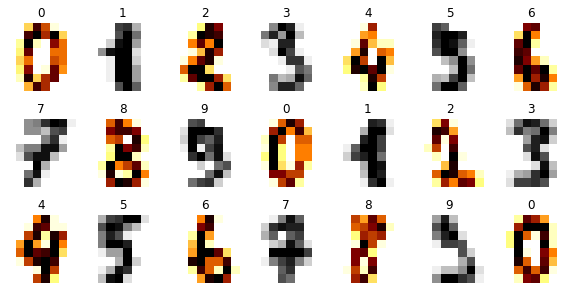

In [190]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [191]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [192]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [193]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [194]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

X.shape (2, 3)
weights.shape (3,)


In [195]:
lr_clf.fit(X_train, y_train)

In [196]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

AssertionError: 

In [197]:
lr_clf.weights_

array([0.0015, 0.    , 0.    , 0.006 , 0.0165, 0.009 , 0.0015, 0.    ,
       0.    , 0.    , 0.    , 0.0175, 0.0215, 0.014 , 0.012 , 0.    ,
       0.    , 0.    , 0.0045, 0.021 , 0.01  , 0.    , 0.013 , 0.003 ,
       0.    , 0.    , 0.0075, 0.02  , 0.004 , 0.    , 0.011 , 0.0055,
       0.    , 0.    , 0.01  , 0.02  , 0.001 , 0.0025, 0.0125, 0.006 ,
       0.    , 0.    , 0.0055, 0.0185, 0.0015, 0.0085, 0.0205, 0.006 ,
       0.    , 0.    , 0.0025, 0.0185, 0.0165, 0.012 , 0.02  , 0.006 ,
       0.    , 0.    , 0.    , 0.0055, 0.019 , 0.0215, 0.011 , 0.002 ,
       0.    ])

In [198]:
model = CustomLogisticRegression()

In [199]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

X.shape (360, 65)
weights.shape (65,)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [200]:
train_acc, test_acc

NameError: name 'train_acc' is not defined

In [201]:
assert min(train_acc, test_acc) > 0.9

NameError: name 'train_acc' is not defined

**(0.5 points)** Visualize the loss history.

In [ ]:
## your code

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [ ]:
## your code

< your thoughts >

**(0.25 points)** Compare zero initialization and random initialization. 

In [ ]:
## your code

< your thoughts >

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(X points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [ ]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        pass
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        pass
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 'your code'
                
            # <your code>
            pass
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        pass

In [ ]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [ ]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [ ]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

In [ ]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [ ]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

In [ ]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(X points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(X points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
## your code

< your thoughts >

**(X points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## your code

< your thoughts >

**(X points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(X points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [491]:
PATH = "data/"

In [492]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [493]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [494]:
data.Sex.value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='Count'>

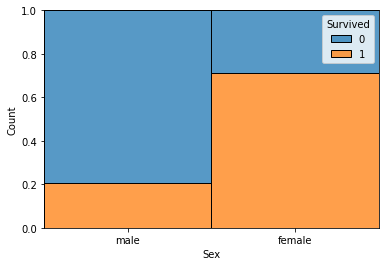

In [495]:
sns.histplot(data=data, x ='Sex', hue="Survived", multiple="fill", binwidth=0.75 , shrink=1)

**You can see that females have a higher survival rate than males.**

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

<AxesSubplot:xlabel='Age', ylabel='Count'>

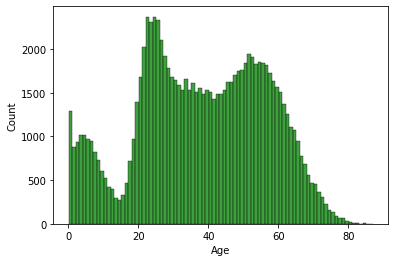

In [496]:
sns.histplot(data=data, x = 'Age', binwidth=1, color='green')

In [497]:
median_age_of_survived = data[(data.Survived == 1)]['Age'].median()
mean_age_of_survived = data[(data.Survived == 1)]['Age'].mean()

median_age_of_deceased = data[(data.Survived == 0)]['Age'].median()
mean_age_of_deceased = data[(data.Survived == 0)]['Age'].mean()

print('median_age_of_survived: ', median_age_of_survived)
print('mean_age_of_survived: ', mean_age_of_survived)
print('median_age_of_deceased', median_age_of_deceased)
print('mean_age_of_deceased', mean_age_of_deceased)

median_age_of_survived:  43.0
mean_age_of_survived:  40.553799314307795
median_age_of_deceased 36.0
mean_age_of_deceased 36.70869488153374


<AxesSubplot:xlabel='Count', ylabel='Age'>

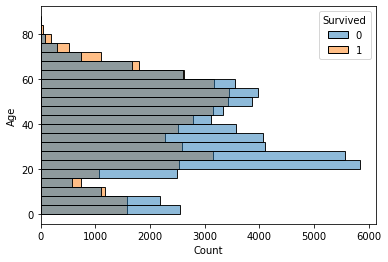

In [498]:
sns.histplot(data=data, y="Age", binwidth=4, hue='Survived')

**As you can see, the chance of surviving increases with age.**

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

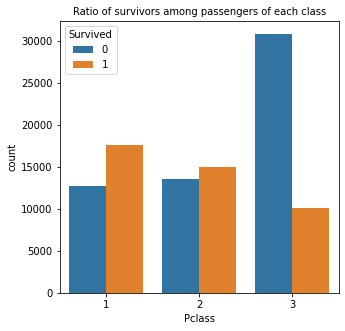

In [499]:
fig = plt.figure(figsize=(5, 5))
sns.countplot(x="Pclass", hue="Survived", data=data);
plt.title("Ratio of survivors among passengers of each class", {"fontsize": 10});

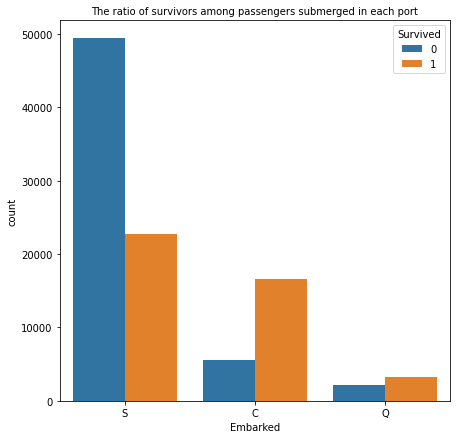

In [500]:
fig = plt.figure(figsize=(7, 7))
sns.countplot(x="Embarked", hue="Survived", data=data);
plt.title("The ratio of survivors among passengers submerged in each port", {"fontsize": 10});

**As can be seen, there are more survivors among the first and second class passengers than among the third class passengers.The reason is that third-class cabins are located on lower decks, and it is therefore difficult for them to get out if anything does happen.**

**Port Southampton was the port from which the most passengers boarded. Passengers who boarded from other ports survived the tragedy better.**

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [501]:
data.isna().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age          3292
SibSp           0
Parch           0
Ticket       4623
Fare          134
Cabin       67866
Embarked      250
dtype: int64

In [502]:
for col in data.columns:
    print('{} - {} %'.format(col, np.mean(data[col].isnull()*100)))

Survived - 0.0 %
Pclass - 0.0 %
Name - 0.0 %
Sex - 0.0 %
Age - 3.292 %
SibSp - 0.0 %
Parch - 0.0 %
Ticket - 4.623 %
Fare - 0.134 %
Cabin - 67.866 %
Embarked - 0.25 %


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

#### Handling with Age feature

In [503]:
df_all_corr = data.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
3,Age,Age,1.000000
11,Age,Pclass,0.259109
17,Age,Parch,0.125535
19,Age,SibSp,0.112459
21,Age,Fare,0.109164
22,Age,Survived,0.103895


Missing values in *Age* are filled with median age, but using median age of the whole data set is not a good choice. Median age of *Pclass* groups is the best choice because of its high correlation with *Age*. It is also more logical to group ages by passenger classes instead of other features.

In order to be more accurate, *Sex* feature is used as the second level of groupby while filling the missing *Age* values. As seen from below, *Pclass* and *Sex* groups have distinct median *Age* values. When passenger class increases, the median age for both males and females also increases. However, females tend to have slightly lower median *Age* than males. The median ages below are used for filling the missing values in *Age* feature.

In [504]:
age_by_pclass_sex = data.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(data['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
data['Age'] = data.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 49.0
Median age of Pclass 1 males: 44.0
Median age of Pclass 2 females: 40.0
Median age of Pclass 2 males: 37.0
Median age of Pclass 3 females: 28.0
Median age of Pclass 3 males: 31.0
Median age of all passengers: 39.0


#### Handling with Embarked feature

In [505]:
# We can check the Embarked median by Pclass.
data.groupby(['Pclass','Embarked'])['Survived'].describe()

count      mean       std  min  25%  50%  75%  max
Pclass Embarked                                                      
1      C         11843.0  0.773959  0.418283  0.0  1.0  1.0  1.0  1.0
       Q          3751.0  0.627299  0.483588  0.0  0.0  1.0  1.0  1.0
       S         14635.0  0.409908  0.491833  0.0  0.0  0.0  1.0  1.0
2      C          6156.0  0.815627  0.387820  0.0  1.0  1.0  1.0  1.0
       Q           844.0  0.654028  0.475966  0.0  0.0  1.0  1.0  1.0
       S         21609.0  0.437040  0.496032  0.0  0.0  0.0  1.0  1.0
3      C          4188.0  0.592646  0.491400  0.0  0.0  1.0  1.0  1.0
       Q           829.0  0.401689  0.490536  0.0  0.0  0.0  1.0  1.0
       S         35895.0  0.203427  0.402553  0.0  0.0  0.0  0.0  1.0

In [506]:
# The median of Embarked in Pclass = 1 is S. Refill the missing Embarked data with S.
data.loc[data['Embarked'].isna(), 'Embarked'] = 'S'

#### Handling with Fare feature

We can assume that Fare is related to family size (Parch and SibSp) and Pclass features. Median Fare value of a male with a third class ticket and no family is a logical choice to fill the missing value.

In [507]:
med_fare = data.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]

data['Fare'] = data['Fare'].fillna(med_fare)

#### Handling with Cabin feature

Cabin has 67000+ missing values so it will also be discarded from out analysis and instead we will use a derived variable cabin_missing.

In [508]:
data['Cabin_Missing'] = data.Cabin.isnull()*1.0
data.drop(['Cabin'], axis=1, inplace=True)

#### Handling with Ticket feature

In [526]:
data_Ticket_unique = data.Ticket.unique()
data_Ticket_not_miss = len(data['Ticket']) - data.isna().sum().Ticket
print('data.Ticket.unique:', len(data_Ticket_unique),'This is ' , len(data_Ticket_unique) /  data_Ticket_not_miss, '%')

data.Ticket.unique: 75332 This is  0.7898340270715162 %


You can see this column has a lot of unique value, therefore it is better to delete it.

In [527]:
data.drop(['Ticket'], axis=1, inplace=True)

In [528]:
# for the same reason, you need to delete the Name column
data.drop(['Name'], axis=1, inplace=True)

In [529]:
data.isna().sum()

Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
Cabin_Missing    0
dtype: int64

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [554]:
data = data.rename_axis(None)
X = data.drop('Survived', axis = 1)
y = data['Survived']

In [556]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X2 = X.copy()
X2.drop(['Cabin_Missing'], axis=1, inplace=True)
X_tmp = X2.apply(le.fit_transform)
X_tmp.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,1,96,2,0,2444,2
1,2,1,70,0,0,1080,2
2,2,1,3,1,2,5720,2
3,2,1,46,0,0,1049,2
4,2,1,58,0,0,521,2


In [532]:
enc = preprocessing.OneHotEncoder()

# 2. FIT
enc.fit(X_2)

# 3. Transform
onehotlabels = enc.transform(X_2).toarray()
onehotlabels.shape

(100000, 196)

In [533]:
X_train, X_test, y_train, y_test = train_test_split(onehotlabels, y, test_size = 0.3, random_state = 0)

#### Logistic Regression

In [429]:
from sklearn.linear_model import LogisticRegression

In [430]:
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

In [431]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.80     17131
           1       0.75      0.69      0.72     12869

    accuracy                           0.77     30000
   macro avg       0.76      0.76      0.76     30000
weighted avg       0.77      0.77      0.77     30000



#### KNN

In [432]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [433]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77     17131
           1       0.69      0.68      0.68     12869

    accuracy                           0.73     30000
   macro avg       0.73      0.73      0.73     30000
weighted avg       0.73      0.73      0.73     30000



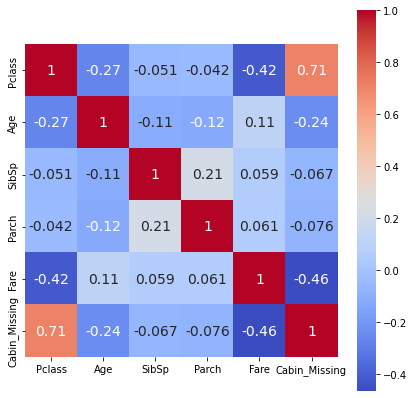

In [461]:
# calculate correlation matrix
fig, axs = plt.subplots(nrows=1, figsize=(7, 7))
X_tmp = data.drop('Survived', axis = 1)
y_tmp = data['Survived']
sns.heatmap(X_tmp.corr(),
            annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
plt.show()

In [462]:
X_tmp.drop(['Cabin_Missing'], axis=1, inplace=True)

In [463]:
X_tmp.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,male,44.00,2,0,27.14,S
1,3,male,31.00,0,0,13.35,S
2,3,male,0.33,1,2,71.29,S
3,3,male,19.00,0,0,13.04,S
4,3,male,25.00,0,0,7.76,S


In [478]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0, 1, 3, 7])], remainder='passthrough')
X_tmp = np.array(ct.fit_transform(X_tmp))

In [479]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_tmp, y_tmp, test_size = 0.3, random_state = 0)

In [480]:
log_reg_new = LogisticRegression(solver='lbfgs', max_iter=10000)
log_reg_new.fit(X_train_new, y_train_new)
y_pred_new = log_reg_new.predict(X_test_new)

In [481]:
from sklearn.metrics import classification_report
print(classification_report(y_test_new,y_pred_new))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80     17131
           1       0.75      0.67      0.71     12869

    accuracy                           0.76     30000
   macro avg       0.76      0.75      0.75     30000
weighted avg       0.76      0.76      0.76     30000



In [482]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.80     17131
           1       0.75      0.69      0.72     12869

    accuracy                           0.77     30000
   macro avg       0.76      0.76      0.76     30000
weighted avg       0.77      0.77      0.77     30000



**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## your code

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.0, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 3.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.